# Show ground tracks on map and estimate unique "actual" lakes

In [3]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from figscode import *

In [4]:
# read in all the shapefiles
out_path_csv = '../data/lakestats_methods_paper.csv'
df = pd.read_csv(out_path_csv)

fn_basin = '../data/shapefiles/Basins_Antarctica_v02.shp'
fn_shelf = '../data/shapefiles/IceShelf_Antarctica_v02.shp'
fn_coast = '../data/shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = '../data/shapefiles/GroundingLine_Antarctica_v02.shp'
fn_merged =  '../data/shapefiles/ANT_basins_merged.shp'
fn_thresh = '../data/shapefiles/ANT_basins_thresh1000.shp'
ant_gdf_basin = gpd.read_file(fn_basin)
ant_gdf_shelf = gpd.read_file(fn_shelf)
ant_gdf_coast = gpd.read_file(fn_coast)
ant_gdf_ground = gpd.read_file(fn_ground)
ant_gdf_merged = gpd.read_file(fn_merged)
ant_gdf_thresh = gpd.read_file(fn_thresh)

fn_basin = '../data/shapefiles/Greenland_Basins_PS_v1.4.2.shp'
fn_merged = '../data/shapefiles/GRE_basins_merged.shp'
fn_thresh = '../data/shapefiles/GRE_basins_thresh2000.shp'
gre_gdf_basin = gpd.read_file(fn_basin)
gre_gdf_basin['geometry'] = gre_gdf_basin.geometry.buffer(1)
gre_gdf_merged = gpd.read_file(fn_merged)
gre_gdf_thresh = gpd.read_file(fn_thresh)
gre_bound = gre_gdf_basin.dissolve().boundary
ant_bound = ant_gdf_basin.dissolve().boundary

fn_gtstats = '../data/lakestats_methods_paper_depth_update_gtextents.csv'
df = pd.read_csv(fn_gtstats)
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf_gt = gpd.GeoDataFrame(df, crs='EPSG:4326')

In [5]:
extent_fns = [
    '../sup-ground-tracks-unique-lakes/data/CW_extent_2019.geojson',
    '../sup-ground-tracks-unique-lakes/data/CW_extent_2020.geojson',
    '../sup-ground-tracks-unique-lakes/data/B-C_extent_2018_19.geojson',
    '../sup-ground-tracks-unique-lakes/data/B-C_extent_2020_21.geojson',
]
crss = [gre_gdf_basin.crs, ant_gdf_basin.crs]
exts = [gpd.read_file(extent_fns[i]).explode(index_parts=False).to_crs(crss[int(i/2)]) for i in range(4)]

seasons = ['2019', '2020', '2018-19', '2020-21']

saved ../figures/supplemental_unique-lakes_CW_2019.jpg
wrote groupings_output/CW_2019_L8extent.csv
wrote groupings_output/CW_2019_unique_lakes_indices.csv
wrote groupings_output/CW_2019_is2_gts.csv


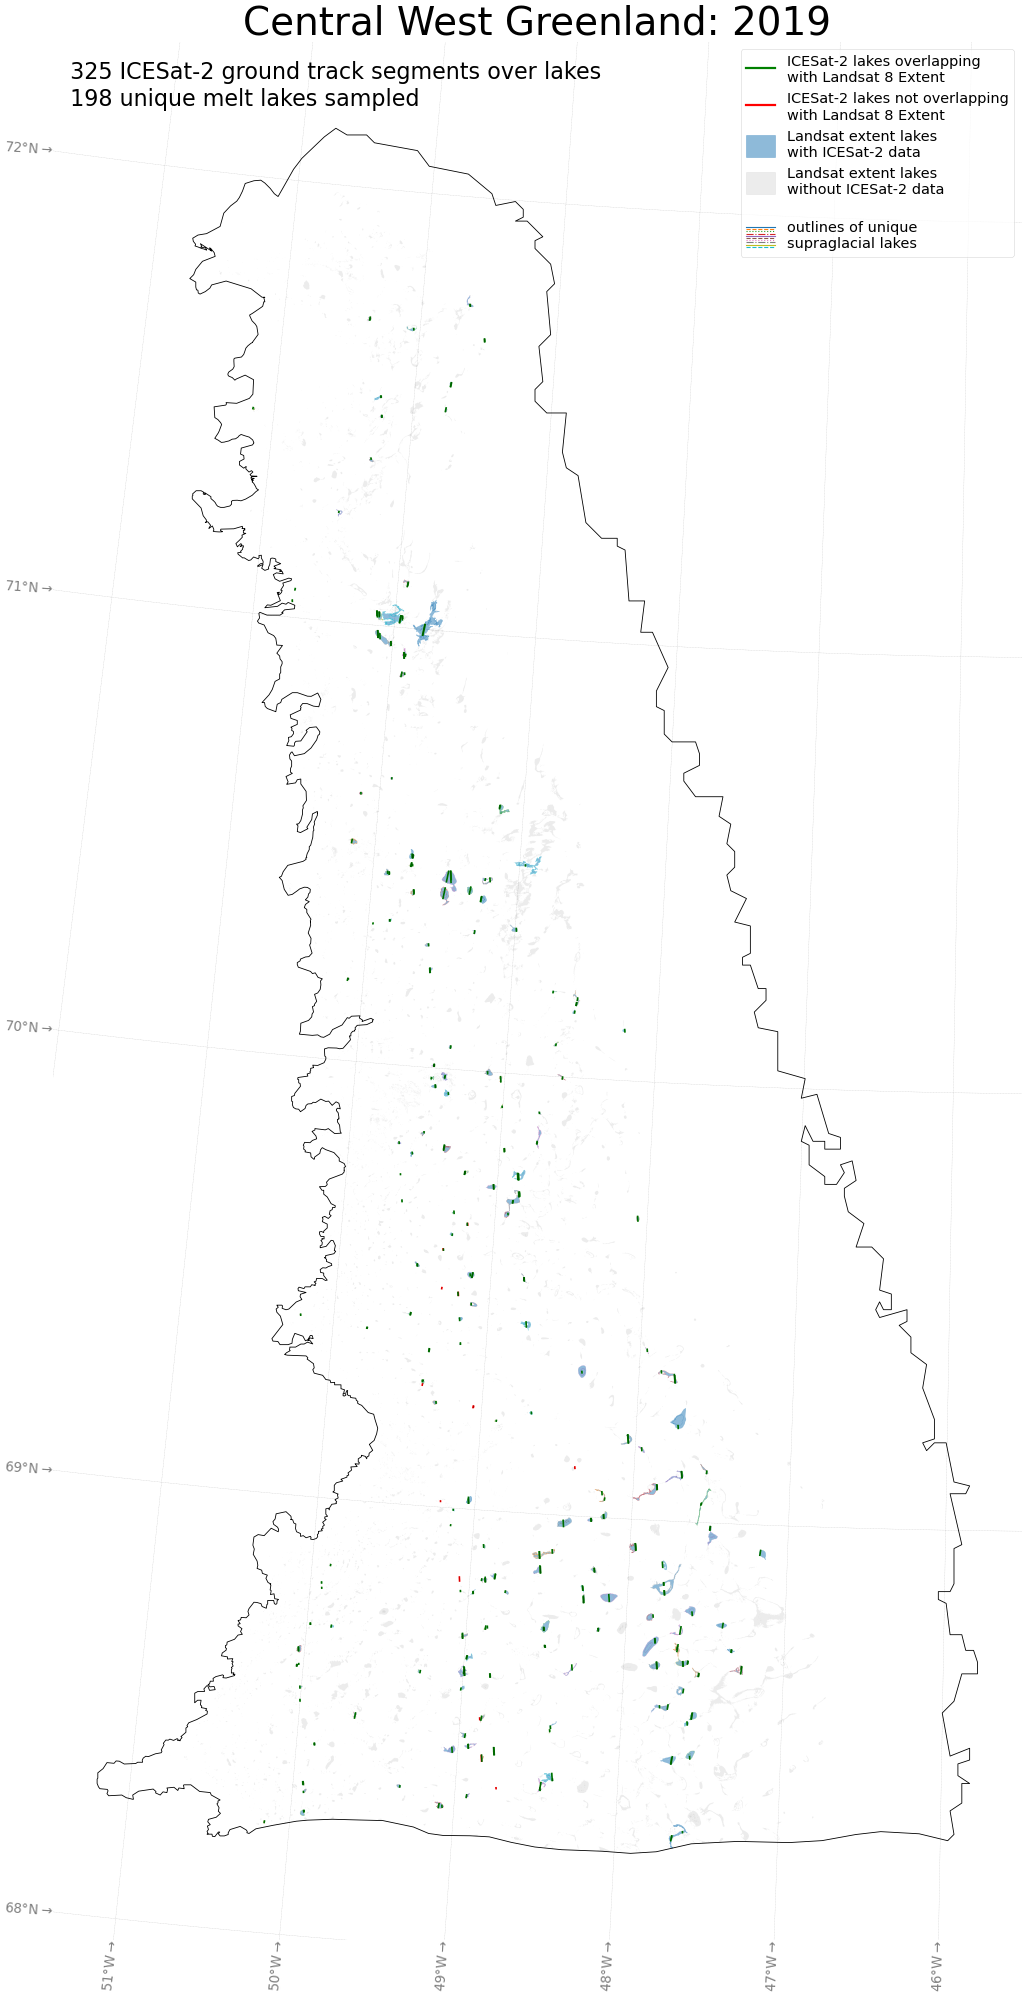

saved ../figures/supplemental_unique-lakes_CW_2020.jpg
wrote groupings_output/CW_2020_L8extent.csv
wrote groupings_output/CW_2020_unique_lakes_indices.csv
wrote groupings_output/CW_2020_is2_gts.csv


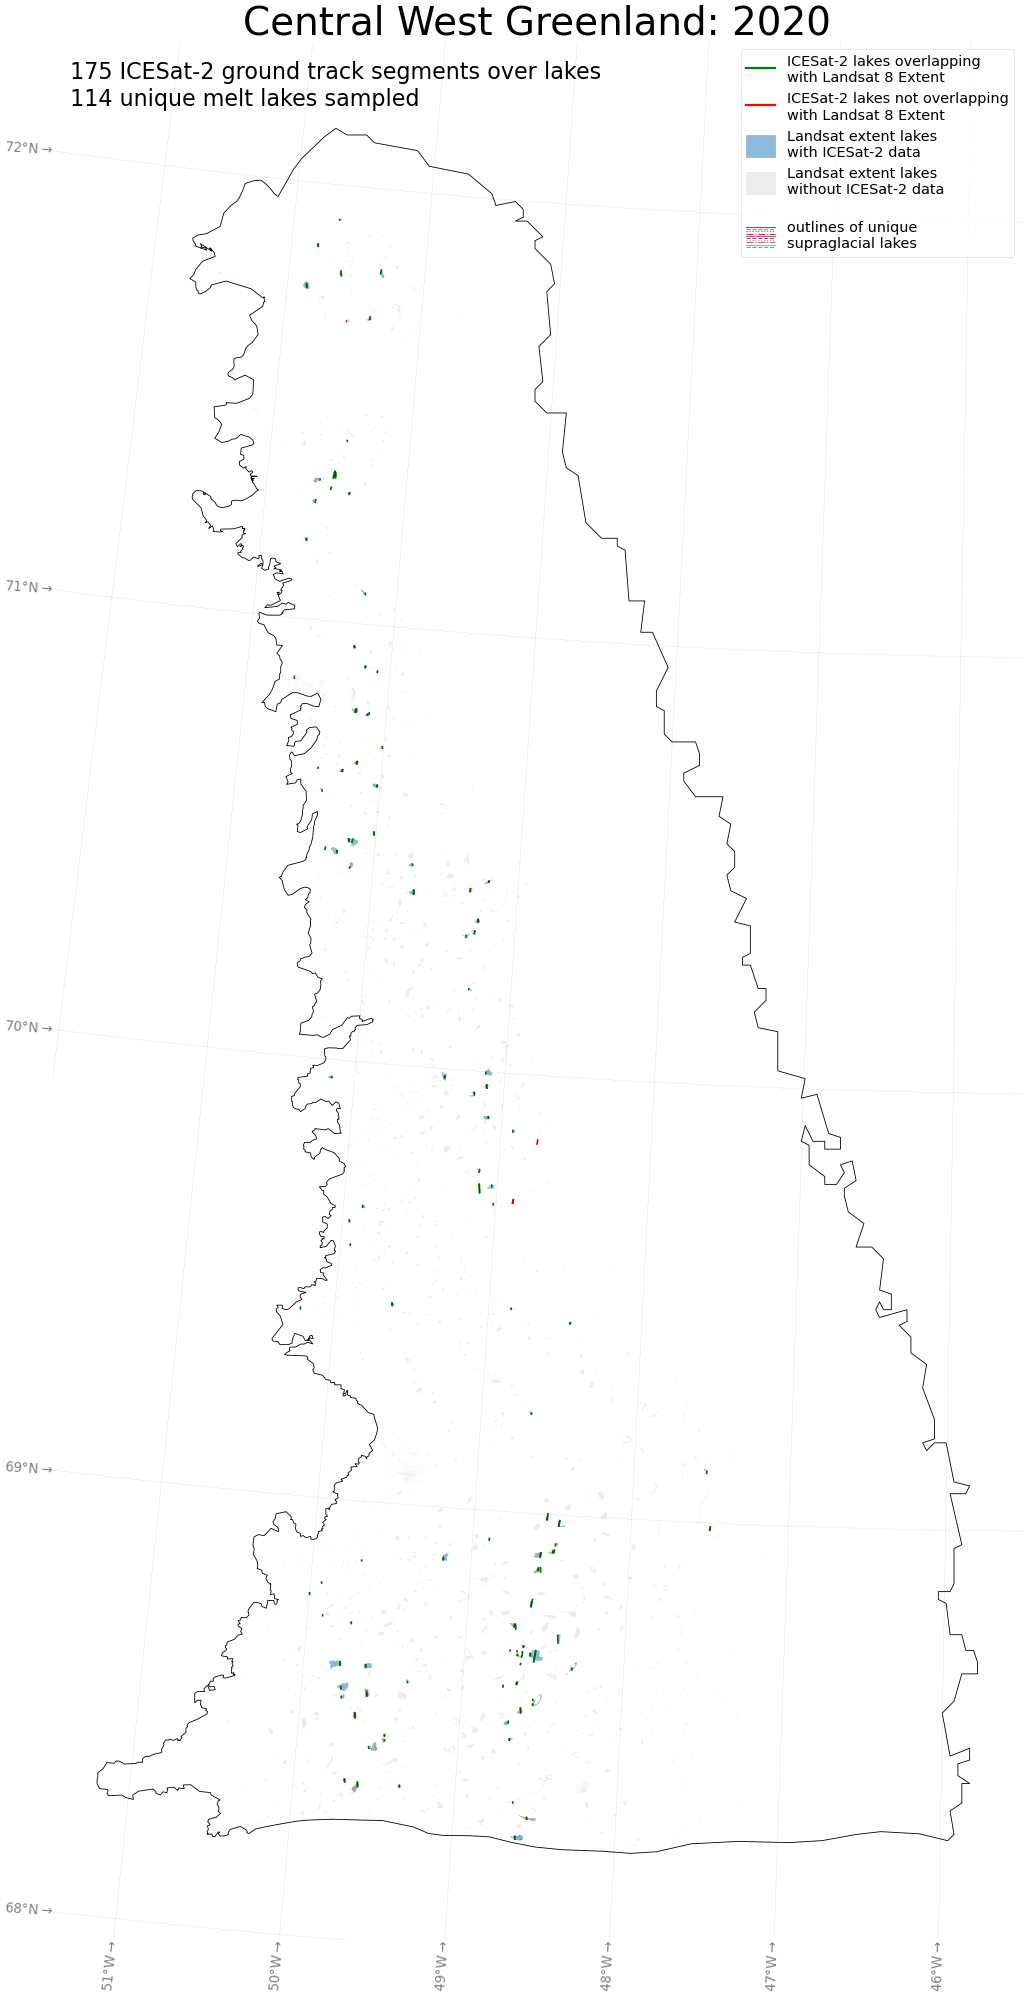

saved ../figures/supplemental_unique-lakes_B-C_2018-19.jpg
wrote groupings_output/B-C_2018-19_L8extent.csv
wrote groupings_output/B-C_2018-19_unique_lakes_indices.csv
wrote groupings_output/B-C_2018-19_is2_gts.csv


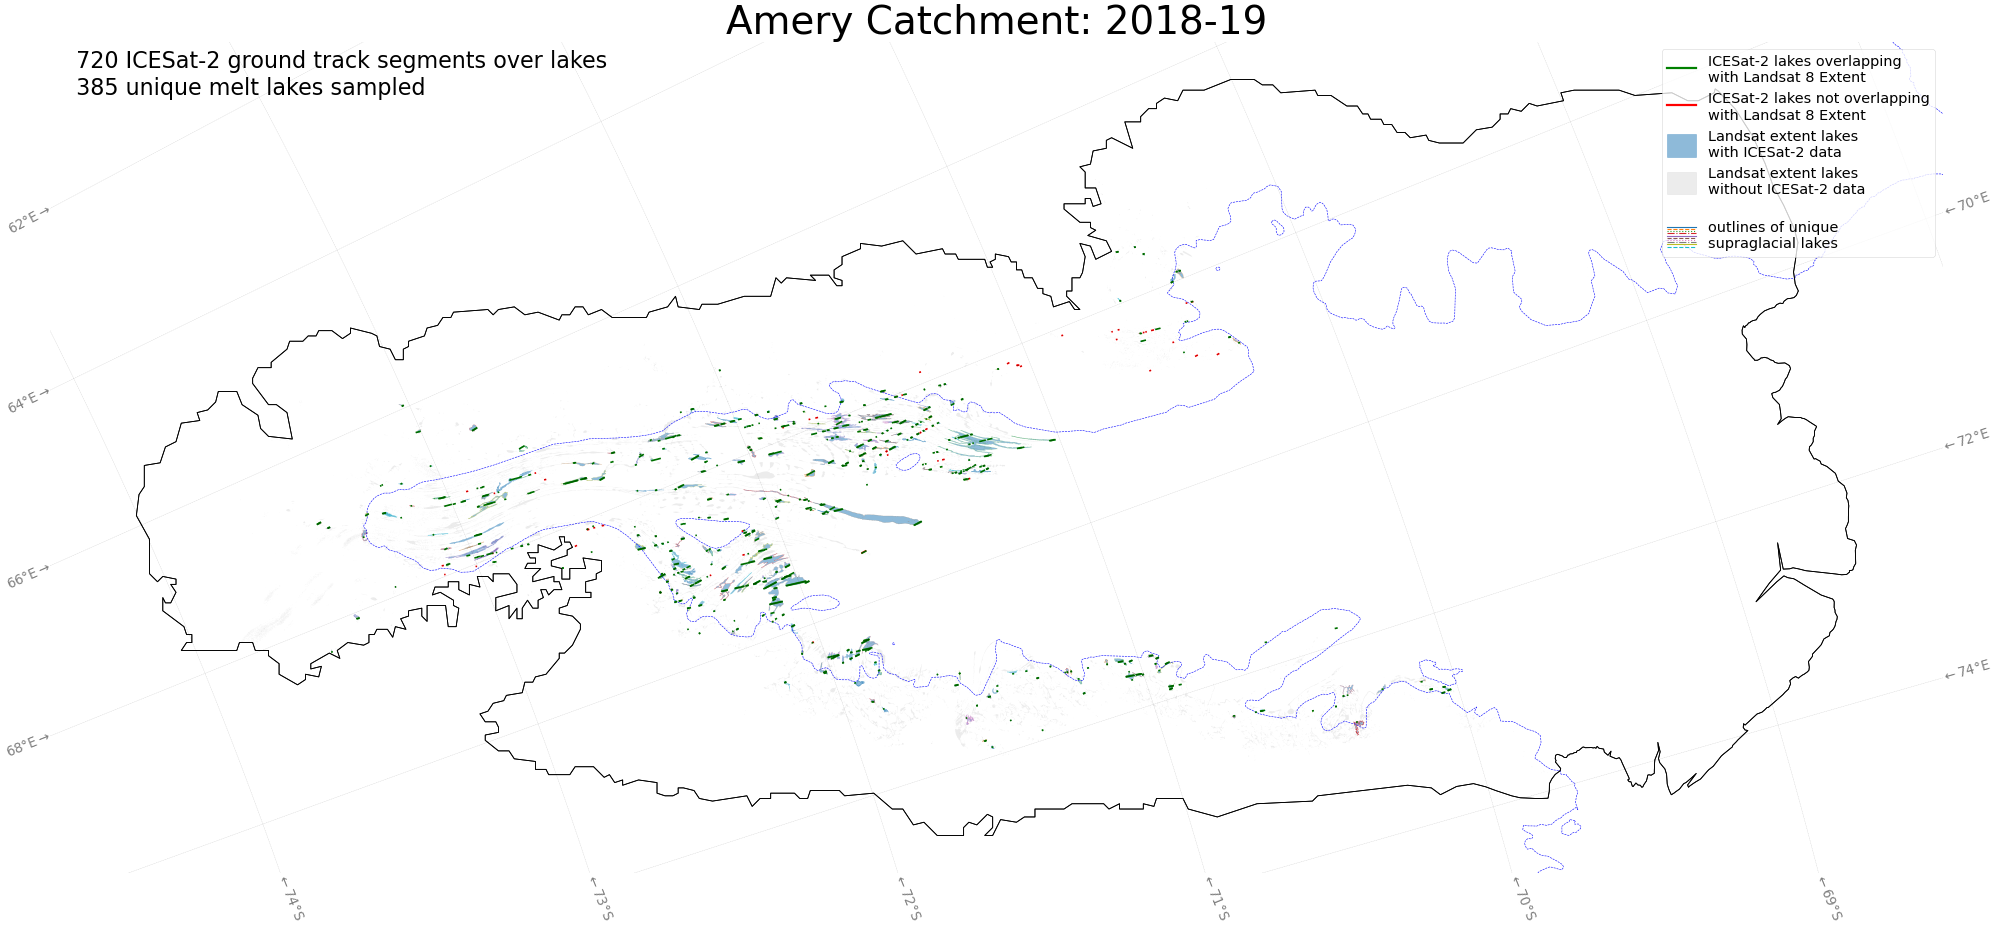

saved ../figures/supplemental_unique-lakes_B-C_2020-21.jpg
wrote groupings_output/B-C_2020-21_L8extent.csv
wrote groupings_output/B-C_2020-21_unique_lakes_indices.csv
wrote groupings_output/B-C_2020-21_is2_gts.csv


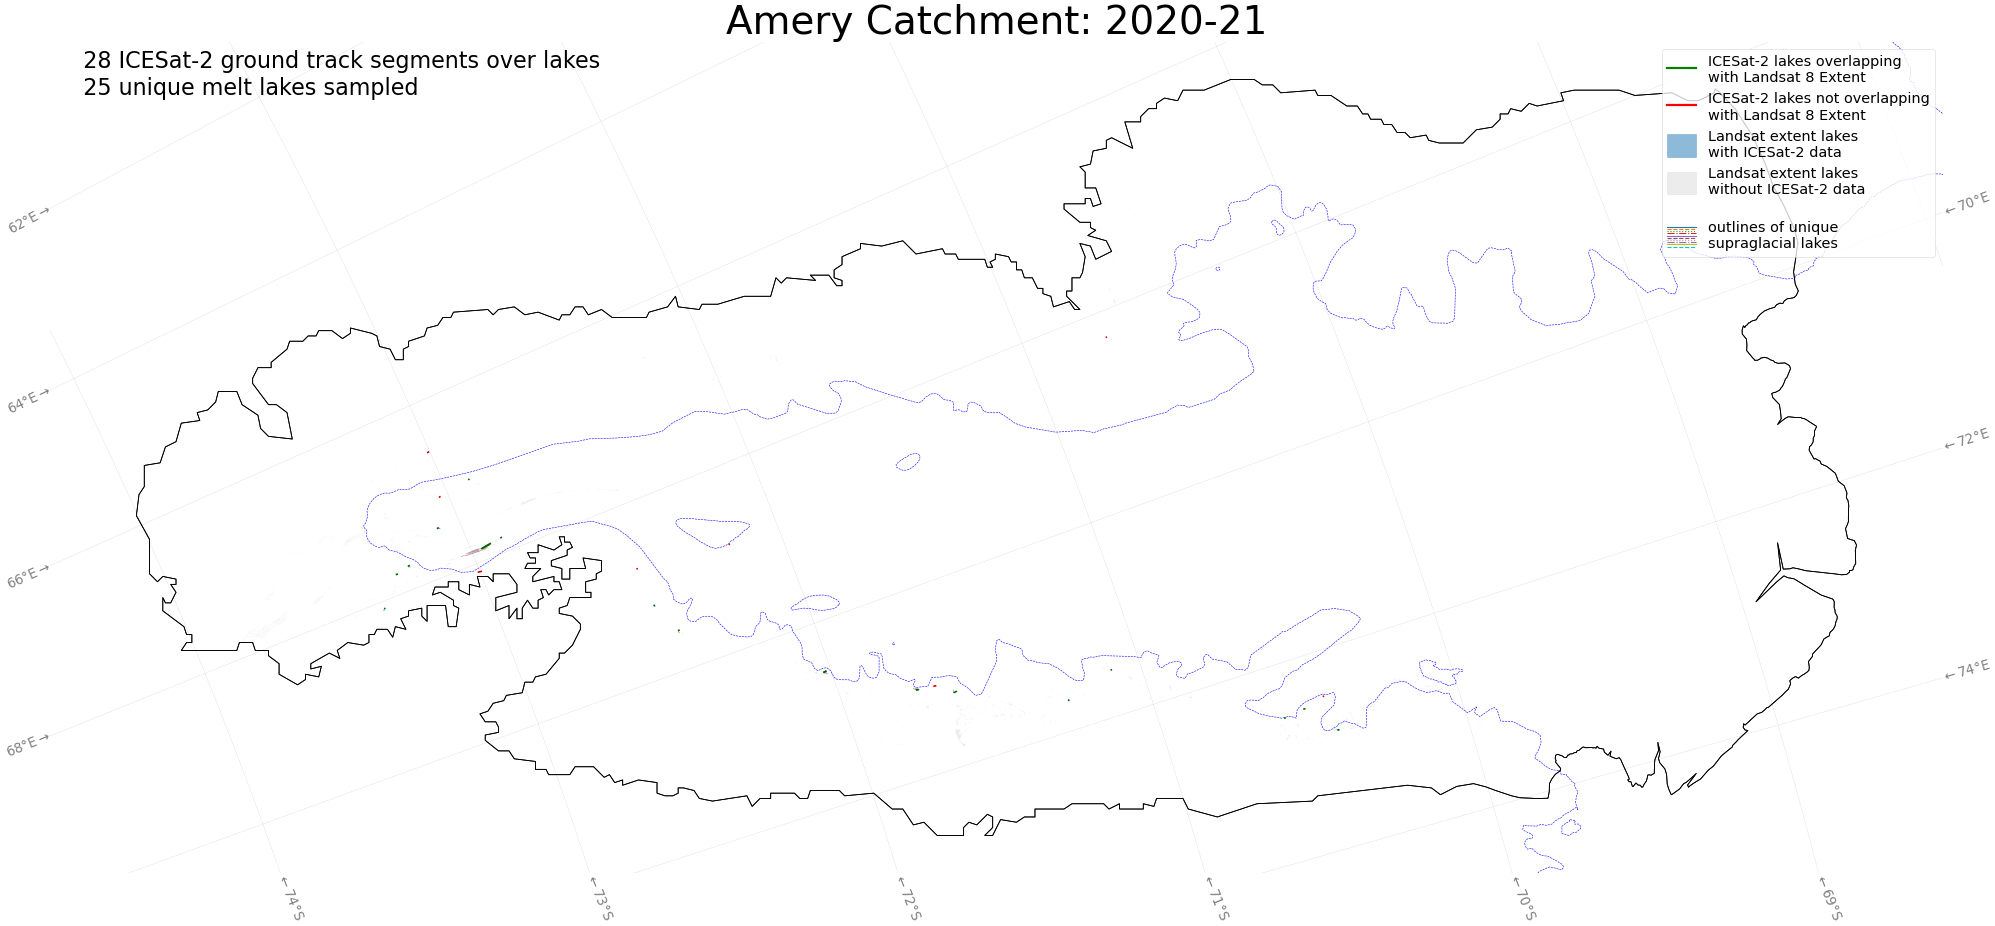

In [38]:
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
class HandlerLinesVertical(HandlerTuple):
    def create_artists(self, legend, orig_handle,
                   xdescent, ydescent, width, height, fontsize,
                   trans):
        ndivide = len(orig_handle)
        a_list = []
        for i, handle in enumerate(orig_handle):
            y = (height / float(ndivide)) * i -ydescent
            line = plt.Line2D(np.array([0,1])*width, [-y,-y])
            line.update_from(handle)
            # line.set_marker(None)
            point = plt.Line2D(np.array([.5])*width, [-y])
            point.update_from(handle)
            for artist in [line, point]:
                artist.set_transform(trans)
            a_list.extend([line,point])
        return a_list
                       
# from matplotlib import pyplot as plt
plt.close('all')
for i, season in enumerate(seasons):
    ext = exts[i]
    icrs = crss[int(i/2)]
    gti = gdf_gt[gdf_gt.melt_season == season].to_crs(icrs).reset_index(names='lake_idx')
    region = gti.basin_name.iloc[0]
    name = 'Central West Greenland' if region == 'CW' else 'Amery Catchment'
    figsz = [30, 50] if region == 'CW' else [50, 30]
    
    fig, ax = plt.subplots(figsize=figsz, dpi=40)
    
    gti[gti.intersects_with_extent].plot(ax=ax, color='g', lw=3, zorder=1000)
    gti[~gti.intersects_with_extent].plot(ax=ax, color='r', ls='-', lw=3, zorder=900)
    green = Line2D([0], [0], color='g', lw=4, label='ICESat-2 lakes overlapping\nwith Landsat 8 Extent')
    red = Line2D([0], [0], color='r', lw=4, label='ICESat-2 lakes not overlapping\nwith Landsat 8 Extent')
    gti.plot(ax=ax, color='k', lw=0.3, zorder=2000)

    if region == 'CW':
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
    else: 
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]

    ext = ext.reset_index(drop=True)
    
    gti['extent_idxs'] = [[] for i in range(len(gti))]
    ext['has_is2'] = False
    for i in gti.index:
        overlaps_gt = gti.loc[i,'geometry'].intersects(ext.geometry)
        ext.loc[overlaps_gt, 'has_is2'] = True
        gti.loc[i,'extent_idxs'].append(list(ext[overlaps_gt].index))

    gti['extent_idxs'] = [x[0] for x in gti.extent_idxs]

    unique_lakes = find_unique_lakes(gti.extent_idxs)
    for iu in unique_lakes.index:
        ext.loc[unique_lakes.loc[iu,'IDs_extent'], 'ID_unique_lake'] = iu

    ext_over = ext[ext.has_is2].copy()
    ext_over['ysort'] = ext_over.apply(lambda x: np.max(x.geometry.exterior.coords.xy[1]), axis=1)
    ext_over = ext_over.dissolve('ID_unique_lake')
    ext_over = ext_over.sort_values(by='ysort').reset_index()
    ext_over['ID_unique_lake'] = ext_over.ID_unique_lake.astype(np.int64)
        
    ext_over.plot(ax=ax, color='C0', alpha=0.5)
    blue = mpatches.Patch(color='C0', alpha=0.5, label='Landsat extent lakes\nwith ICESat-2 data')
    ext[~ext.has_is2].plot(ax=ax, color='gray', alpha=0.15)
    gray = mpatches.Patch(color='gray', alpha=0.15, label='Landsat extent lakes\nwithout ICESat-2 data')
    nlines = len(ext_over)
    cols = matplotlib.colormaps['tab10'](np.arange(nlines) % 10)
    lst = ['-', '--', ':', '-.']
    lss = np.array(lst)[[int((x/10) % len(lst)) for x in range(nlines)]]
    hdls = []
    for j in range(len(cols)):
        try:
            ext_over.iloc[[j]].buffer(10).plot(ax=ax, facecolor='none', lw=0.3, edgecolor=cols[j], ls=lss[j], label='unique lake border')
        except:
            pass

    for j in range(10):
        h = Line2D([0], [0], color=cols[j], ls=lst[j%len(lst)], label='unique lake borders', lw=2)
        hdls.append(h)
        
    if region == 'B-C':
        region_thresh.exterior.plot(ax=ax, color='k')
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        ant_gdf_ground.plot(ax=ax, edgecolor='b', facecolor='none', ls='--')
        ax.set_xlim(xl)
        ax.set_ylim(yl)
    region_thresh.exterior.plot(ax=ax, color='k')

    # add legend
    ax.legend(handles = [tuple(hdls)], labels=["borders\nof unique\nlakes"], handler_map={tuple:HandlerLinesVertical()},
           handleheight=7 )
    handles = [green, red, blue, gray]
    labels = [handles[i].get_label() for i in range(len(handles))] + ['\noutlines of unique\nsupraglacial lakes']
    handles += [tuple(hdls)]
    ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=26, handler_map={tuple:HandlerLinesVertical()}, handleheight=2)

    # add unique lake stats
    txt = '%4i ICESat-2 ground track segments over lakes' % len(gti)
    txt += '\n%4i unique melt lakes sampled' % len(unique_lakes)
    ax.text(0.01, 0.99, txt, fontsize=40, transform=ax.transAxes, ha='left', va='top')
    
    ax.set_title('%s: %s' % (name, season), fontsize=70)
    ax.axis('off')
    if region == 'CW':
        meridians_locs=['bottom']
        parallels_locs=['left']
    else:
        meridians_locs=['left', 'right']
        parallels_locs=['bottom']
        
    add_graticule(region_thresh, ax, fontsz=24, meridians_locs=meridians_locs,parallels_locs=parallels_locs)
    fig.tight_layout()

    figfn = '../figures/supplemental_unique-lakes_%s_%s.jpg' % (region, season)
    fig.savefig(figfn, dpi=600)
    # fig.savefig('supplemental_test_unique-lakes_%s_%s.jpg' % (region, season), dpi=600)
                
    print('saved %s' % figfn)

    extfn = 'groupings_output/%s_%s_L8extent.csv' % (region, season)
    ext_over.to_csv(extfn)
    print('wrote %s' % extfn)

    ulfn = 'groupings_output/%s_%s_unique_lakes_indices.csv' % (region, season)
    unique_lakes.to_csv(ulfn)
    print('wrote %s' % ulfn)

    gtifn = 'groupings_output/%s_%s_is2_gts.csv' % (region, season)
    gti.to_csv(gtifn)
    print('wrote %s' % gtifn)

    plt.close(fig)
    display(fig)

In [ ]:
lst = ['-', '--', ':', '-.']
np.array(lst)[[(x % len(lst)) for x in range(10)]]

In [ ]:
[(x % len(lst)) for x in range(10)]

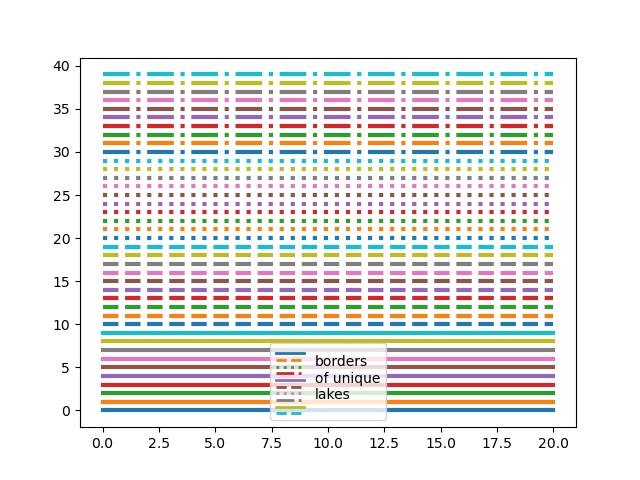

In [25]:

nlines = 40
cols = matplotlib.colormaps['tab10'](np.arange(nlines) % 10)
lst = ['-', '--', ':', '-.']
lss = np.array(lst)[[int((x/10) % len(lst)) for x in range(nlines)]]
fig, ax = plt.subplots()
for i in range(len(cols)):
    ax.plot([0, 20], [i, i], color=cols[i], lw=3, ls=lss[i])

hdls=[]
for j in range(10):
    h = Line2D([0], [0], color=cols[j], ls=lst[j%len(lst)], label='unique lake borders', lw=2)
    hdls.append(h)

from matplotlib.legend_handler import HandlerTuple
class HandlerLinesVertical(HandlerTuple):
    def create_artists(self, legend, orig_handle,
                   xdescent, ydescent, width, height, fontsize,
                   trans):
        ndivide = len(orig_handle)
        a_list = []
        for i, handle in enumerate(orig_handle):
            y = (height / float(ndivide)) * i -ydescent
            line = plt.Line2D(np.array([0,1])*width, [-y,-y])
            line.update_from(handle)
            # line.set_marker(None)
            point = plt.Line2D(np.array([.5])*width, [-y])
            point.update_from(handle)
            for artist in [line, point]:
                artist.set_transform(trans)
            a_list.extend([line,point])
        return a_list


ax.legend(handles = [tuple(hdls)], labels=["borders\nof unique\nlakes"], handler_map={tuple:HandlerLinesVertical()},
           handleheight=7 )


In [31]:
[hdls[i].get_label() for i in range(len(hdls))]

['unique lake borders',
 'unique lake borders',
 'unique lake borders',
 'unique lake borders',
 'unique lake borders',
 'unique lake borders',
 'unique lake borders',
 'unique lake borders',
 'unique lake borders',
 'unique lake borders']